In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.mlab as mlab
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import math
import seaborn as sns
from six.moves import cPickle as pickle
import csv
import sys
import pandas as pd
import time

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy import stats

import matplotlib.lines as mlines
import re
from scipy import optimize

import matplotlib.colors as colors2
import matplotlib.cm as cmx

import numpy.polynomial.polynomial as poly

from sklearn import linear_model

from scipy.interpolate import interp1d

from pyemd import emd
# https://github.com/wmayner/pyemd
# Ofir Pele and Michael Werman, "Fast and robust earth mover's distances," in Proc. 2009 IEEE 
# 12th Int. Conf. on Computer Vision, Kyoto, Japan, 2009, pp. 460-467.

from multiprocessing import Pool

%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, 'grid.linewidth': 0.})
# sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
#                'in', 'xtick.major.size': 4.0, 'ytick.direction': 'in', 'ytick.major.size': 4.0, \
#                'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, \
#               'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.})


In [3]:
# load the data
consumption_df = pd.read_pickle('../cleanedLoadData/consumption_df_round3.pickle')

In [4]:
consumption_df.head()

,user_id,cities,states,2015-01-01 00:00:00,2015-01-01 00:15:00,2015-01-01 00:30:00,2015-01-01 00:45:00,2015-01-01 01:00:00,2015-01-01 01:15:00,2015-01-01 01:30:00,...,2015-12-31 21:30:00,2015-12-31 21:45:00,2015-12-31 22:00:00,2015-12-31 22:15:00,2015-12-31 22:30:00,2015-12-31 22:45:00,2015-12-31 23:00:00,2015-12-31 23:15:00,2015-12-31 23:30:00,2015-12-31 23:45:00
1,3935,Austin,Texas,0.327,0.230,0.224,0.222,0.199,0.189,0.188,...,0.180,0.213,0.203,0.220,0.229,0.179,0.0,0.0,0.0,0.0
2,668,Austin,Texas,0.380,0.270,0.246,0.193,0.204,0.215,0.219,...,0.095,0.060,0.060,0.079,0.117,0.089,0.0,0.0,0.0,0.0
3,6412,Austin,Texas,0.484,0.329,0.292,0.222,0.215,0.220,0.230,...,0.223,0.194,0.233,0.223,0.203,0.215,0.0,0.0,0.0,0.0
4,5814,Austin,Texas,0.369,0.235,0.047,0.096,0.093,0.028,0.027,...,0.114,0.113,0.113,0.095,0.091,0.091,0.0,0.0,0.0,0.0
5,8046,Austin,Texas,0.169,0.131,0.093,0.072,0.087,0.072,0.088,...,0.183,0.190,0.181,0.176,0.290,0.251,0.0,0.0,0.0,0.0


In [5]:
print 'There are now', len(consumption_df), 'users'

There are now 255 users


In [9]:
len(consumption_df.user_id.unique())

326

In [10]:
cIDs = consumption_df.user_id.unique()

In [11]:
consumption_df = consumption_df.set_index('user_id')

In [12]:
min15_df = consumption_df.iloc[:,2:]

In [13]:
min15Vals = min15_df.iloc[:,:].values

In [14]:
# change the vals to hourly
[a,b] = np.shape(min15Vals)
hourlyVals = np.zeros((a,b/4))
for j in range(b/4):
    hourlyVals[:,j] = np.sum(min15Vals[:,j*4+0:(j+1)*4], axis=1)

In [15]:
# make an hourly dataframe
colsT = pd.date_range(start='1/1/2015', end='1/1/2016', freq='1H')[0:-1]
print len(colsT)
hourly_df = pd.DataFrame(hourlyVals, index=np.arange(a), columns=colsT)

8760


In [16]:
hourly_df['user_id'] = cIDs

In [17]:
hourly_df = hourly_df.set_index('user_id')

In [18]:
# first lets look at the consumption data - aggregate plus a couple of individual
aggregateLoad = hourly_df.sum(axis=0)

In [19]:
len(aggregateLoad)

8760

In [20]:
hourly_df.head()

,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,2015-01-01 08:00:00,2015-01-01 09:00:00,...,2015-12-31 14:00:00,2015-12-31 15:00:00,2015-12-31 16:00:00,2015-12-31 17:00:00,2015-12-31 18:00:00,2015-12-31 19:00:00,2015-12-31 20:00:00,2015-12-31 21:00:00,2015-12-31 22:00:00,2015-12-31 23:00:00
user_id,,,,,,,,,,,,,,,,,,,,,
3935,1.003332,0.764315,0.868050,0.170085,0.271533,0.212950,0.353380,0.705767,0.789635,0.919065,...,0.802600,0.367565,0.567135,0.665917,0.938865,0.688485,0.426032,0.755833,0.830985,0.0
668,1.090333,0.831383,0.827715,0.772167,0.819035,0.798118,0.808468,0.881833,1.864865,2.883665,...,1.066800,0.477685,0.488715,0.523415,1.166635,1.015783,0.593732,0.305550,0.345247,0.0
6412,1.327083,0.831035,0.838150,0.817985,0.751003,1.535483,1.356750,1.005717,1.796735,5.176902,...,0.521717,0.599017,0.839017,1.471085,1.523235,1.411517,1.300415,0.873600,0.874265,0.0
5814,0.746615,0.174850,0.254500,0.268483,0.193085,0.276785,0.265200,0.169835,0.707700,0.690717,...,0.190315,0.367085,0.422018,0.455050,1.015432,0.825065,0.457785,0.479300,0.389733,0.0
8046,0.465750,0.338567,0.317670,0.527885,1.261783,1.298500,1.354182,1.603382,2.131420,2.314267,...,0.525350,0.525700,1.001783,0.892100,0.829600,0.880583,0.836732,0.800700,0.898735,0.0


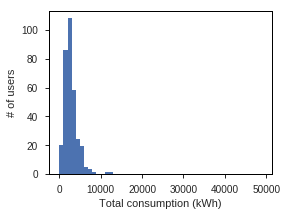

In [21]:
# plot a histogram of consumption
consTotal = hourly_df.sum(axis=1).values/4
consBins = np.arange(0,50000,1000)
consHist, consEdges = np.histogram(consTotal, consBins, density=False)
widths = consEdges[1:]-consEdges[0:-1]
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
ax1.bar(consEdges[0:-1]+widths/2,consHist,width=widths)
ax1.set_xlabel('Total consumption (kWh)')
ax1.set_ylabel('# of users')

* the weather data is in UTC!

In [22]:
# load in the temperature data
weatherFile2015 = './weatherData/CRNH0203-2015-TX_Austin_33_NW.txt'
weatherFile2016 = './weatherData/CRNH0203-2016-TX_Austin_33_NW.txt'

hourlyTemp = np.zeros((8760))
with open(weatherFile2015, 'rb') as inFile:
    lineCount = 0
    for line in inFile:
        if lineCount>=6:
            hourlyTemp[lineCount-6] = re.sub('\s+',',',line.strip()).split(',')[9]
            if lineCount == 6:
                print line
        lineCount+=1
        
print lineCount
        
with open(weatherFile2016, 'rb') as inFile:
    for line in inFile:
        hourlyTemp[lineCount-6] = re.sub('\s+',',',line.strip()).split(',')[9]
        lineCount+=1
        if lineCount-6>=8760:
            break

23907 20150101 0700 20150101 0100  2.423  -98.08   30.62     0.2     0.3     0.4     0.2     0.0      0 0      0 0      0 0 C     2.6 0     2.7 0     2.5 0    88 0   0.327   0.287 -99.000 -99.000 -99.000     7.2     8.5 -9999.0 -9999.0 -9999.0

8760


In [23]:
hourlyTemp[-10:]

array([ 9.6,  9.2,  8.6,  8.3,  8. ,  7.8,  7.7,  7.6,  7.3,  7. ])

In [24]:
# strip out values where == -9999
missingLabel = min(hourlyTemp)
print len(np.where(hourlyTemp==missingLabel)[0])
badIndices = np.where(hourlyTemp==missingLabel)[0]

61


In [25]:
badIndices

array([1479, 1480, 1481, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520,
       1521, 1522, 3491, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822,
       3823, 3824, 3825, 3826, 3827, 3828, 3925, 3926, 3927, 3928, 3929,
       3930, 3931, 3932, 3933, 3977, 3978, 3979, 3980, 3981, 3982, 4020,
       4021, 4022, 4023, 4024, 4026, 4041, 4042, 4043, 7072, 7073, 7329,
       7545, 7546, 7547, 7548, 7668, 8197])

In [26]:
def get_interp_windows(badIndices):
    windows = []
    considered = np.ones((len(badIndices)))
    j=0
    while any(considered==1):
        #print j
        # consider +- 10 hours
        lowerLimit = badIndices[j]-10
        offset = 1

        # add in if len to stop err
        if j<len(considered)-1:
            while badIndices[j+offset] == badIndices[j]+offset:
                offset+=1
            upperLimit = badIndices[j]+offset+9
            # find the next j
            considered[j:j+offset]=0
            j = j+offset
        else:
            considered[j]=0
            upperLimit = badIndices[j]+offset+9
        windows.append([lowerLimit,upperLimit])
    return windows

In [27]:
interpWindows = get_interp_windows(badIndices)
print interpWindows

[[1469, 1491], [1503, 1532], [3481, 3501], [3805, 3838], [3915, 3943], [3967, 3992], [4010, 4034], [4016, 4036], [4031, 4053], [7062, 7083], [7319, 7339], [7535, 7558], [7658, 7678], [8187, 8207]]


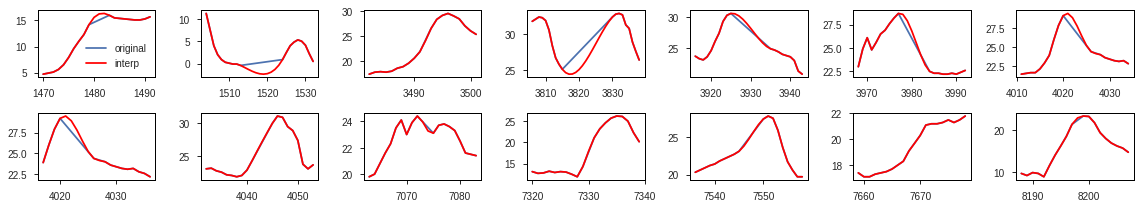

In [28]:
# now lets interpolate to get missing temperature values
timePlot = np.arange(1,len(hourlyTemp)+1)
hourlyTemp[badIndices]=np.nan
hourlyTempInterp = np.copy(hourlyTemp)
fig = plt.figure(figsize=(16,3)) # there are 14 windows
axs = []
for j in range(len(interpWindows)):
    axs.append(fig.add_subplot(len(interpWindows)/7,7,j+1))

for j,window in enumerate(interpWindows):
    test = hourlyTemp[window[0]:window[1]]
    timeWindow = timePlot[window[0]:window[1]]
    hours = timeWindow[~np.isnan(test)]
    test = test[~np.isnan(test)]
    # now let's interp this
    f1 = interp1d(hours, test, kind='cubic')
    # now include the interp values
    hourlyTempInterp[window[0]:window[1]] = f1(timeWindow)
    
    l1, = axs[j].plot(hours,test)
    l2, = axs[j].plot(timeWindow,hourlyTempInterp[window[0]:window[1]],color='r')
    
axs[0].legend([l1,l2],['original','interp'])
fig.tight_layout()

In [29]:
hourlyTemp = hourlyTempInterp

In [30]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*(x-x0)+y0, lambda x:k2*(x-x0)+y0])

In [31]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
          'November', 'December']
daynum = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [32]:
np.sum(daynum[0:13])

365

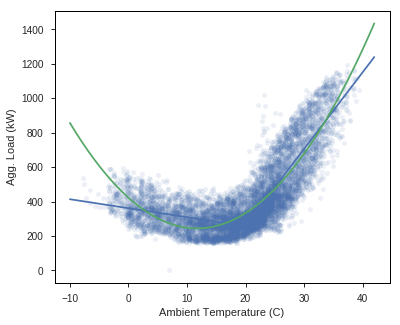

In [33]:
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111)
ax1.scatter(hourlyTemp,hourly_df.sum(axis=0),marker='o',s=20,alpha=0.1)
p , e = optimize.curve_fit(piecewise_linear, hourlyTemp,hourly_df.sum(axis=0))
#print ['%.2f'%e for e in p]
xd = np.linspace(-10,42,101)
ax1.plot(xd, piecewise_linear(xd, *p))

coefs = poly.polyfit(hourlyTemp, hourly_df.sum(axis=0), 2)
#print coefs
ffit = poly.polyval(xd, coefs)

ax1.plot(xd, ffit)

ax1.set_xlabel('Ambient Temperature (C)')
ax1.set_ylabel('Agg. Load (kW)')

Look at temperture in different months at different time periods <br>
**Both piecewise and third order polynominals are typically used for the load-temperature relationship. <br>

In [34]:
# highOcc = np.arange(17,24)
# lowOcc = np.arange(0,17)
nightTime = np.asarray([23,0,1,2,3,4])
earlyMorn = np.asarray([5,6,7,8])
dayTime = np.asarray([9,10,11,12,13,14,15])
eveningTime = np.asarray([16,17,18,19,20,21,22,23])
timeLists = [nightTime, earlyMorn, dayTime, eveningTime]
lineStyles = ['-','-.',':','--']

In [35]:
##### lets train on data up until September
startTrain = np.int(np.sum(daynum[0:months.index('January')])*24)
endTrain = np.int(np.sum(daynum[0:months.index('September')])*24)

# get all new features
startPred = np.int(np.sum(daynum[0:months.index('September')])*24)
endPred = np.int(np.sum(daynum[0:months.index('November')])*24)
lenPrediction = endPred-startPred
print 'The training length = %d hours'%(endTrain-startTrain)
print 'The prediction length = %d hours'%lenPrediction

The training length = 5832 hours
The prediction length = 1464 hours


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


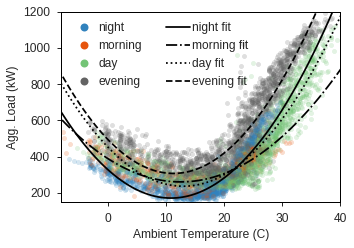

In [36]:
#create colormap
minVal, maxVal = 1, 24.
cmOcc = plt.cm.get_cmap('tab20c')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

fig = plt.figure(figsize=(5,3.5))
nDays = np.int((endTrain-startTrain)/24)
hourlyTempReshape = hourlyTemp[startTrain:endTrain].reshape(nDays,24)
loadReshape = aggregateLoad[startTrain:endTrain].reshape(nDays,24)
ax1 = fig.add_subplot(111)
for k in range(24):
    #cl = scalarMap3.to_rgba((np.float(k+1)))
    if k in nightTime:
        cl = scalarMap3.to_rgba((1))
    elif k in earlyMorn:
        cl = scalarMap3.to_rgba((6))
    elif k in dayTime:
        cl = scalarMap3.to_rgba((12))
    elif k in eveningTime:
        cl = scalarMap3.to_rgba((20))

    else:
        print 'Oops'
    cl = colors2.rgb2hex(cl)
    ax1.scatter(hourlyTempReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.2, color=cl)

colorIndex = [1,6,12,20]
colorsO = []
############ FIT POLYNOMIAL AT EACH TIME BLOCK ##########
for k in range(4):
    coefs = poly.polyfit(hourlyTempReshape[:,timeLists[k]].flatten(),loadReshape[:,timeLists[k]].flatten(), 2)
    ffit = poly.polyval(xd, coefs)
    plt.plot(xd, ffit, color='k', linestyle=lineStyles[k])
    cl = scalarMap3.to_rgba((colorIndex[k]))
    colorsO.append(colors2.rgb2hex(cl))

ax1.set_xlabel('Ambient Temperature (C)', fontsize=12)
ax1.set_ylabel('Agg. Load (kW)', fontsize=12)
ax1.set_ylim([150,1200])
ax1.set_xlim([np.floor(np.min(hourlyTempReshape)),np.ceil(np.max(hourlyTempReshape))])
ax1.tick_params(axis='both', labelsize=12)

proxys = [ plt.plot([],[], marker="o", ms=8, ls="", mec=None, color=colorsO[i])[0] for i in range(4) ]
for k in range(4):
    proxys.append( mlines.Line2D([], [], color='k', linestyle=lineStyles[k]) )

plt.legend(proxys, ['night', 'morning', 'day', 'evening', 'night fit', 'morning fit', 'day fit', 'evening fit'],\
           ncol=2, numpoints=1, fontsize=12, handletextpad=0.2)

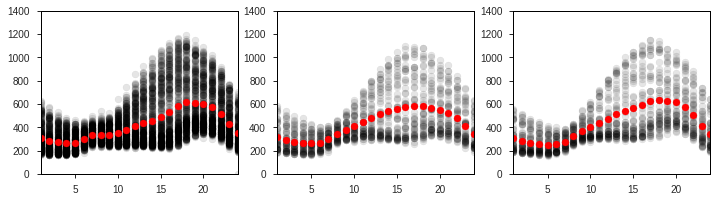

In [37]:
# plot weekdays, sat and sun all aggregate consumption
fig = plt.figure(figsize=(12,3))
axs = []
for j in range(3):
    axs.append( fig.add_subplot(1,3,j+1))
    
start = 0
end = 24
weekdays, saturdays, sundays = [], [], []
for j in range(365):
    dayConsumption = aggregateLoad[start:end]
    # get the day of week
    day_of_week = dayConsumption.index[0]
    day_of_week = day_of_week.dayofweek
    if day_of_week in [0,1,2,3,4]:
        axs[0].scatter(np.arange(1,25),dayConsumption,color='k',alpha=0.1)
        weekdays.append(dayConsumption)
    elif day_of_week in [5]:
        axs[1].scatter(np.arange(1,25),dayConsumption,color='k',alpha=0.1)
        saturdays.append(dayConsumption)
    else:
        axs[2].scatter(np.arange(1,25),dayConsumption,color='k',alpha=0.1)
        sundays.append(dayConsumption)
    start+=24
    end+=24
for ax in axs:
    ax.set_xlim([1,24])
    ax.set_ylim([0,1400])

axs[0].scatter(np.arange(1,25),np.mean(weekdays, axis=0),color='r')
axs[1].scatter(np.arange(1,25),np.mean(saturdays, axis=0),color='r')
axs[2].scatter(np.arange(1,25),np.mean(sundays, axis=0),color='r')

In [38]:
# restrict for only looking at certain months?
start = np.int(np.sum(daynum[0:months.index('January')])*24)
end = np.int(np.sum(daynum[0:months.index('December')])*24)
end = 8760
print start, end

0 8760


In [39]:
hourly_df = hourly_df.iloc[:,start:end]
hourlyTemp = hourlyTemp[start:end]

In [40]:
hourly_df.head()

,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,2015-01-01 08:00:00,2015-01-01 09:00:00,...,2015-12-31 14:00:00,2015-12-31 15:00:00,2015-12-31 16:00:00,2015-12-31 17:00:00,2015-12-31 18:00:00,2015-12-31 19:00:00,2015-12-31 20:00:00,2015-12-31 21:00:00,2015-12-31 22:00:00,2015-12-31 23:00:00
user_id,,,,,,,,,,,,,,,,,,,,,
3935,1.003332,0.764315,0.868050,0.170085,0.271533,0.212950,0.353380,0.705767,0.789635,0.919065,...,0.802600,0.367565,0.567135,0.665917,0.938865,0.688485,0.426032,0.755833,0.830985,0.0
668,1.090333,0.831383,0.827715,0.772167,0.819035,0.798118,0.808468,0.881833,1.864865,2.883665,...,1.066800,0.477685,0.488715,0.523415,1.166635,1.015783,0.593732,0.305550,0.345247,0.0
6412,1.327083,0.831035,0.838150,0.817985,0.751003,1.535483,1.356750,1.005717,1.796735,5.176902,...,0.521717,0.599017,0.839017,1.471085,1.523235,1.411517,1.300415,0.873600,0.874265,0.0
5814,0.746615,0.174850,0.254500,0.268483,0.193085,0.276785,0.265200,0.169835,0.707700,0.690717,...,0.190315,0.367085,0.422018,0.455050,1.015432,0.825065,0.457785,0.479300,0.389733,0.0
8046,0.465750,0.338567,0.317670,0.527885,1.261783,1.298500,1.354182,1.603382,2.131420,2.314267,...,0.525350,0.525700,1.001783,0.892100,0.829600,0.880583,0.836732,0.800700,0.898735,0.0


### Look at some random households in random months

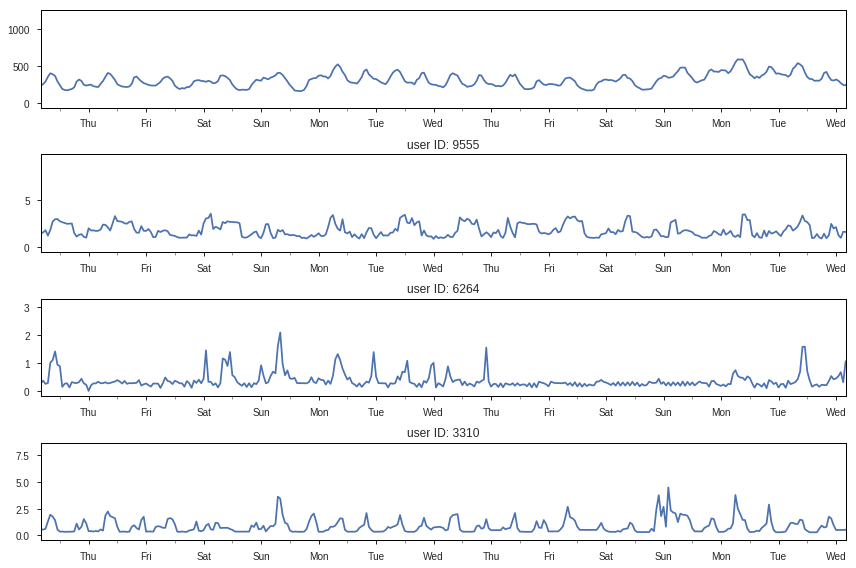

In [41]:
noPlots = 4
users_to_highlight = [203,22,105]
idHighlight = [hourly_df.index[u] for u in users_to_highlight]

fig = plt.figure(figsize=(12,8))
axs = []
window = [1000+0,1000+24*14]

dayLabels = ['Mon', 'Tue', 'Wed', 'Thu','Fri','Sat','Sun']

indexVals = aggregateLoad.index
# find the first tick
for j,ind in enumerate(indexVals):
    if j >=window[0]:
        if ind.hour == 0:
            startTick =0+j
            break

for i in range(1,noPlots+1):
    axs.append(fig.add_subplot(noPlots,1,i))
for i in range(noPlots):
    if i in [0]: # plot the aggregate load
        plotVals = aggregateLoad.values
        
        axs[i].plot(timePlot,plotVals)
    else:
        uID = idHighlight[i-1]
        plotVals = hourly_df.loc[uID] #consumption_df[consumption_df['user_id']==uID].iloc[0,3:]
        axs[i].plot(timePlot,plotVals)
        
    axs[i].set_xlim(window)
    axs[i].set_xticks(np.arange(startTick,window[1],12), minor=True)
    axs[i].set_xticks(np.arange(startTick+12,window[1],24))
    tickLabs = []
    for ti in np.arange(startTick+12,window[1],24):
        tickLabs.append(dayLabels[indexVals[window[0]+ti].dayofweek])
    axs[i].set_xticklabels(tickLabs)
    if i>0:
        axs[i].set_title('user ID: %d'%uID)
fig.tight_layout()
# 2015 starts on thursday

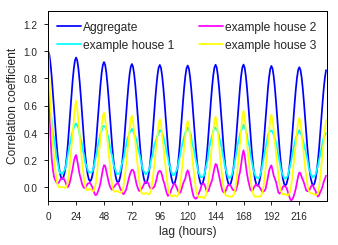

In [42]:
nD = 10
colors = ['b', 'cyan', 'magenta', 'yellow']
fig = plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111)
proxys = []
for i in range(4):      
    # now lets look at autocorrelation of the load
    if i==0:
        loadNorm = aggregateLoad-aggregateLoad.mean()
    else:
        uID = idHighlight[i-1]
        loadNorm = hourly_df.loc[uID]-hourly_df.loc[uID].mean()
    lagNWeeks = np.zeros((24*nD))
    for j in range(len(lagNWeeks)):
        lagNWeeks[j] = loadNorm.autocorr(lag=j)
    
    l, = ax1.plot(np.arange(24*nD),lagNWeeks,color=colors[i])
    proxys.append(l)
ax1.set_xlabel('lag (hours)', fontsize=12)
ax1.set_ylabel('Correlation coefficient', fontsize=12)
ax1.set_xlim([0,24*nD])
ax1.set_xticks(np.arange(0,24*nD,24));
ax1.set_ylim([-0.1,1.3])

legLabs = []
legLabs.append('Aggregate')
for i in range(3):
    #legLabs.append('user ID: %d'%idHighight[i])
    legLabs.append('example house %d'%(i+1))
plt.legend(proxys, legLabs,\
           ncol=2, fontsize=12, handletextpad=0.2)

In [43]:
featureLength = endPred-(startTrain+168) # we need to train on 24 hours behind

In [44]:
aggIndices = aggregateLoad.index
T_to_F = [1,2,3,4]
S_to_M = [5,6,0]

In [45]:
### what are the holidays 
# Thursday, January 1
# Monday, January 19
# Monday, February 16
# Monday, May 25
# Friday, July 3
# Monday, September 7
# Monday, October 12
# Wednesday, November 11
# Thursday, November 26
# Friday, December 25
# a = aggIndices[0]
# a.dayofyear

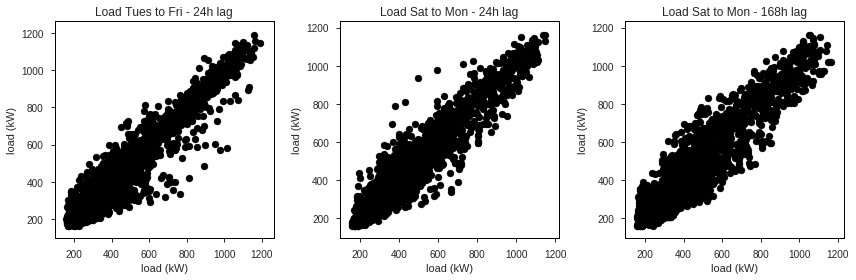

In [46]:
# scatter plot of load against load at previous time one day earlier
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
# loop through the days
for day in range((endTrain/24)-1):
    startIndex = (day+1)*24
    dayOfWeek = aggIndices[startIndex].dayofweek
    if dayOfWeek in T_to_F:
        ax1.scatter(aggregateLoad[startIndex-24:startIndex], aggregateLoad[startIndex:startIndex+24], color='k')
    else:
        ax2.scatter(aggregateLoad[startIndex-24:startIndex], aggregateLoad[startIndex:startIndex+24], color='k')
        if day>6:
            ax3.scatter(aggregateLoad[startIndex-168:startIndex-144], aggregateLoad[startIndex:startIndex+24], color='k')
ax1.set_title('Load Tues to Fri - 24h lag')
ax2.set_title('Load Sat to Mon - 24h lag')
ax3.set_title('Load Sat to Mon - 168h lag')
ax1.set_xlabel('load (kW)'), ax1.set_ylabel('load (kW)')
ax2.set_xlabel('load (kW)'), ax2.set_ylabel('load (kW)')
ax3.set_xlabel('load (kW)'), ax3.set_ylabel('load (kW)')
fig.tight_layout()

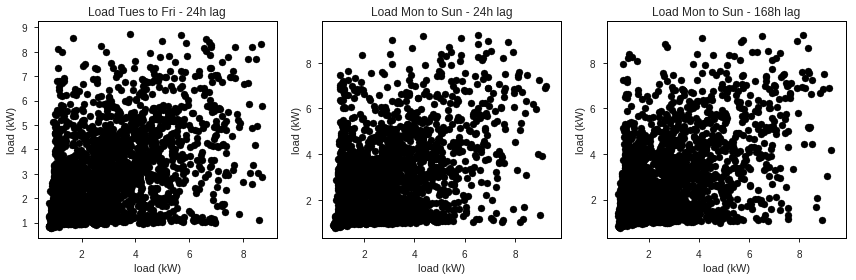

In [47]:
# scatter plot of load against load at previous time one day earlier
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
# loop through the days

uID = idHighlight[0]
testLoad = hourly_df.loc[uID]

for day in range((endTrain/24)-1):
    startIndex = (day+1)*24
    dayOfWeek = aggIndices[startIndex].dayofweek
    if dayOfWeek in T_to_F:
        ax1.scatter(testLoad[startIndex-24:startIndex], testLoad[startIndex:startIndex+24], color='k')
    else:
        ax2.scatter(testLoad[startIndex-24:startIndex], testLoad[startIndex:startIndex+24], color='k')
        if day>6:
            ax3.scatter(testLoad[startIndex-168:startIndex-144], testLoad[startIndex:startIndex+24], color='k')
ax1.set_title('Load Tues to Fri - 24h lag')
ax2.set_title('Load Mon to Sun - 24h lag')
ax3.set_title('Load Mon to Sun - 168h lag')
ax1.set_xlabel('load (kW)'), ax1.set_ylabel('load (kW)')
ax2.set_xlabel('load (kW)'), ax2.set_ylabel('load (kW)')
ax3.set_xlabel('load (kW)'), ax3.set_ylabel('load (kW)')
fig.tight_layout()

# Decide on the possible model features

start with an initial model:
$ \hat{P}_{t} = \beta_0 + TF_{t}\beta_{1}P_{t-24} + SM_{t}\beta_{2}P_{t-24} + TF_{t}\beta_{3}P_{t-168} + SM_{t}\beta_{4}P_{t-168} +
\sum_{i=1}^{4} [daySection_{t}^{(i)}(\beta_{5,i}T_t+\beta_{6,i}T_t^2+\beta_{7,i}T_t^3)] $ <br>
* TF - Tuesday to Friday <br>
* SM - Saturday to Monday <br>
* We assume we know temperature (rather than forecast)
* there are 4 daySections (night, morning, afternoon, evening) which can have different tempertaure responses

In [48]:
dayClassifier = [[1,2,3,4],[5,6,0]]
# at the moment there are 2 24 lag features, 2 168 lag, 12 temperature
allFeatures = np.zeros((featureLength,16))
#allFeatures[:,0] = aggregateLoad[startTrain:endTrain-24]
yData = aggregateLoad[startTrain+168:endPred]
interestTemp = hourlyTemp[startTrain+168:endPred]
for j in range(len(yData)):
    hourTrain = yData.index[j].hour
    dayTrain = yData.index[j].dayofweek
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])*aggregateLoad[(startTrain+168)+j-24] #24 hours before
    allFeatures[j,0:2] = dummy# features 0&1
    
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])*aggregateLoad[startTrain+j]
    allFeatures[j,2:4] = dummy# features 2&3
    
    dummy = np.zeros((len(timeLists)*3))
    for k in range(len(timeLists)):
        dummy[3*k:3*(k+1)] = (hourTrain in timeLists[k])
        dummy[3*k] = dummy[3*k]*interestTemp[j]
        dummy[3*k+1] = dummy[3*k+1]*(interestTemp[j]**2)
        dummy[3*k+2] = dummy[3*k+2]*(interestTemp[j]**3)*0
    allFeatures[j,4:] = dummy

### Training Data

In [49]:
# remember we do not have features for the first week
allFeaturesTrain = allFeatures[startTrain:endTrain-168,:]

### Prediction data

In [50]:
# again, remeber no features for the first week
allFeaturesPredict = allFeatures[startPred-168:endPred-168,:]

In [51]:
np.shape(allFeaturesPredict)

(1464, 16)

In [52]:
# now make the models

In [53]:
# Model with quadratic temperature
clfQuadraticTemp = linear_model.LinearRegression(fit_intercept=True)
clfQuadraticTemp.fit(allFeaturesTrain, yData[startTrain:endTrain-168])
coefQuadraticTemp = clfQuadraticTemp.coef_

In [54]:
# temperature unaware model
clfTempUnaware = linear_model.LinearRegression(fit_intercept=True)
clfTempUnaware.fit(allFeaturesTrain[:,0:4], yData[startTrain:endTrain-168])
coefTempUnaware = clfTempUnaware.coef_

In [55]:
# Now look at the results on the validation period

In [56]:
# lets look at the predicted and actual load for the month of september
actual = aggregateLoad[startPred:endPred]
predictedQuadraticTemp = np.zeros((np.shape(actual)))
predictedTempUnaware = np.zeros((np.shape(actual)))
seasonalNaive1 = aggregateLoad[startPred-24:endPred-24].values
seasonalNaive2 = aggregateLoad[startPred-168:endPred-168].values

# predict using the cubic temp model
predictedQuadraticTemp = clfQuadraticTemp.predict(allFeaturesPredict)
# predict using the temp unaware model
predictedTempUnaware = clfTempUnaware.predict(allFeaturesPredict[:,0:4])

## Riccardo, here I would also like to use the features to train a neural net. 
The features are in an array called allFeaturesTrain. <br>
Features in columns 0 and 1 are the load 24 hours previous X a dummy variable for day of week <br>
Features in columns 2 and 3 are the load168 hours previous X a dummy variable for day of week <br>
Features 4-16 are temperature <br>
The above trains the model on allFeaturesTrain to fit yData. <br>
I want to create a neaural net for predicting the load (like the regression above) and also for each individual (see below)

In [6]:
# fig = plt.figure(figsize = (14,6))
# axs = []
# #nModels = 3
# window = [0,336]
# plotStart, plotEnd = startPred+window[0], startPred+window[1]
# titles = ['Seasonal Naive models', 'Regression models']

# for j in range(2):
#     axs.append(fig.add_subplot(2,1,j+1))
    
# indexVals = actual.index
# # find the first tick
# j = startPred+window[0]
# for ind in indexVals:
#     if j >= plotStart:
#         if ind.hour == 0:
#             startTick = 0+j
#             break
#     j+=1
    
# for j in range(2):
#     axs[j].plot(np.arange(plotStart,plotEnd), actual[window[0]:window[1]], color='k', linestyle='--')
#     if j == 0:
#         axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive1[window[0]:window[1]], color='b', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive2[window[0]:window[1]], color='r', linestyle='-')
#     elif j == 1:
#         axs[j].plot(np.arange(plotStart,plotEnd), predictedTempUnaware[window[0]:window[1]], color='g', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), predictedQuadraticTemp[window[0]:window[1]], color='r', linestyle='-')
#     axs[j].set_xlim([plotStart,plotEnd])
#     axs[j].set_title(titles[j])
#     axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
#     axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
#     tickLabs = []
#     for ti in np.arange(startTick+12,plotEnd,24):
#         tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
#     axs[j].set_xticklabels(tickLabs)
# fig.tight_layout()

In [7]:
# #create colormap which has EUI
# minVal, maxVal = 0, 60.
# cmOcc = plt.cm.get_cmap('Oranges')
# cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
# scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
# scalarMap3._A = []

# # Look at each day in the forecast period
# fig = plt.figure(figsize = (12,3))
# ax1 = fig.add_subplot(131)
# counter = 0
# for row in actual.reshape(lenPrediction/24,24):
#     cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
#     cl = colors2.rgb2hex(cl)
#     ax1.plot(np.arange(1,25),row,color=cl)
#     counter+=1
# ax1.set_title('aggregate load'), ax1.set_xlim([1,24]), ax1.set_ylabel('load (kW)'), ax1.set_xlabel('time');

# # look at the same for two random individuals
# actualInd = hourly_df.loc[idHighlight[0]][startPred:endPred]
# ax1 = fig.add_subplot(132)
# counter = 0
# for row in actualInd.reshape(lenPrediction/24,24):
#     cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
#     cl = colors2.rgb2hex(cl)
#     ax1.plot(np.arange(1,25),row,color=cl)
#     counter+=1
# ax1.set_title('Individual %d load'%idHighlight[0]), ax1.set_xlim([1,24]), ax1.set_ylabel('load (kW)'), ax1.set_xlabel('time');

# # look at the same for two random individuals
# actualInd = hourly_df.loc[idHighlight[1]][startPred:endPred]
# ax1 = fig.add_subplot(133)
# counter = 0
# for row in actualInd.reshape(lenPrediction/24,24):
#     cl = scalarMap3.to_rgba((counter/np.float(lenPrediction/24))*60)
#     cl = colors2.rgb2hex(cl)
#     ax1.plot(np.arange(1,25),row,color=cl)
#     counter+=1
# ax1.set_title('Individual %d load'%idHighlight[1]), ax1.set_xlim([1,24]), ax1.set_ylabel('load (kW)'), ax1.set_xlabel('time');
# plt.subplots_adjust(wspace=0.3)

# cbar_ax = plt.axes([0.93, 0.2, 0.02, 0.6])
# cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,60,10), orientation='vertical')
# cbar_ax.tick_params(axis='both', which='major')
# cbar.set_label('Day number', labelpad=9, rotation=90)
# #fig.savefig('daily_load_evolution_aggregate_vs_individual.png', dpi=300, format='png',  bbox_inches='tight')

In [59]:
len(seasonalNaive1-actual)

1464

In [60]:
# calculate MAPE's for the forecast
APEs = np.zeros((lenPrediction,4))
APEs[:,0] = np.abs(seasonalNaive1-actual)/np.abs(actual)
APEs[:,1] = np.abs(seasonalNaive2-actual)/np.abs(actual)
APEs[:,2] = np.abs(predictedTempUnaware-actual)/np.abs(actual)
APEs[:,3] = np.abs(predictedQuadraticTemp-actual)/np.abs(actual)

In [61]:
MAPEs = np.mean(APEs, axis=0)

In [8]:
# fig = plt.figure(figsize=(3.5,2))
# plt.bar([0,1,2,3],MAPEs*100)
# plt.ylabel('Error (%)')
# print MAPEs

In [63]:
hourly_df.head()

,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,2015-01-01 08:00:00,2015-01-01 09:00:00,...,2015-12-31 14:00:00,2015-12-31 15:00:00,2015-12-31 16:00:00,2015-12-31 17:00:00,2015-12-31 18:00:00,2015-12-31 19:00:00,2015-12-31 20:00:00,2015-12-31 21:00:00,2015-12-31 22:00:00,2015-12-31 23:00:00
user_id,,,,,,,,,,,,,,,,,,,,,
3935,1.003332,0.764315,0.868050,0.170085,0.271533,0.212950,0.353380,0.705767,0.789635,0.919065,...,0.802600,0.367565,0.567135,0.665917,0.938865,0.688485,0.426032,0.755833,0.830985,0.0
668,1.090333,0.831383,0.827715,0.772167,0.819035,0.798118,0.808468,0.881833,1.864865,2.883665,...,1.066800,0.477685,0.488715,0.523415,1.166635,1.015783,0.593732,0.305550,0.345247,0.0
6412,1.327083,0.831035,0.838150,0.817985,0.751003,1.535483,1.356750,1.005717,1.796735,5.176902,...,0.521717,0.599017,0.839017,1.471085,1.523235,1.411517,1.300415,0.873600,0.874265,0.0
5814,0.746615,0.174850,0.254500,0.268483,0.193085,0.276785,0.265200,0.169835,0.707700,0.690717,...,0.190315,0.367085,0.422018,0.455050,1.015432,0.825065,0.457785,0.479300,0.389733,0.0
8046,0.465750,0.338567,0.317670,0.527885,1.261783,1.298500,1.354182,1.603382,2.131420,2.314267,...,0.525350,0.525700,1.001783,0.892100,0.829600,0.880583,0.836732,0.800700,0.898735,0.0


In [64]:
len(hourly_df)

326

### Now look at the forecasts for single users

In [65]:
np.shape(allFeatures)

(7128, 16)

In [66]:
featureLength

7128

In [67]:
endPred-(startTrain+168)

7128

In [68]:
nUsers = len(hourly_df)
allFeaturesIndividual = np.zeros((featureLength,12+4*nUsers))

# temperature based features (interact with hour)
allFeaturesIndividual[:,0:12] = allFeatures[:,4:]

for nU in range(nUsers):
    allFeaturesIndividual[:,12+(4*nU)] = hourly_df.iloc[nU][startTrain+144:endPred-24].values
    allFeaturesIndividual[:,12+(4*nU+1)] = hourly_df.iloc[nU][startTrain+144:endPred-24].values
    allFeaturesIndividual[:,12+(4*nU+2)] = hourly_df.iloc[nU][startTrain:endPred-168].values
    allFeaturesIndividual[:,12+(4*nU+3)] = hourly_df.iloc[nU][startTrain:endPred-168].values

# day interact with 1 week and 1 week before features
for j in range(featureLength):
    dayTrain = yData.index[j].dayofweek
    
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])
        
    for nU in range(nUsers):
        allFeaturesIndividual[j,12+(4*nU)] = dummy[0]*allFeaturesIndividual[j,12+(4*nU)]
        allFeaturesIndividual[j,12+(4*nU+1)] = dummy[1]*allFeaturesIndividual[j,12+(4*nU+1)]
        
    dummy = np.zeros((len(dayClassifier)))
    for k in range(len(dayClassifier)):
        dummy[k] = (dayTrain in dayClassifier[k])
        
    for nU in range(nUsers):
        allFeaturesIndividual[j,12+(4*nU+2)] = dummy[0]*allFeaturesIndividual[j,12+(4*nU+2)]
        allFeaturesIndividual[j,12+(4*nU+3)] = dummy[1]*allFeaturesIndividual[j,12+(4*nU+3)]

### Training data

In [69]:
# remember we do not have features for the first week
allFeaturesIndividualTrain = allFeaturesIndividual[startTrain:endTrain-168,:]

### Prediction data

In [70]:
# again, remember we do not have features for the first week!!
allFeaturesIndividualPredict = allFeaturesIndividual[startPred-168:endPred-168,:]

In [71]:
predQuadraticTempIndividual = np.zeros((nUsers, len(actual)))
predTempUnawareIndividual = np.zeros((nUsers, len(actual)))
seasonalNaive1Individual = np.zeros((nUsers, len(actual)))
seasonalNaive2Individual = np.zeros((nUsers, len(actual)))

for nU in range(nUsers):
    seasonalNaive1Individual[nU,:] = hourly_df.iloc[nU,startPred-24:endPred-24].values
    seasonalNaive2Individual[nU,:] = hourly_df.iloc[nU,startPred-168:endPred-168].values

for nU in range(nUsers):
    columns = []
    for j in range(12):
        columns.append(j)
    for j in range(12+(nU*4),12+(nU*4+4)):
        columns.append(j)
    
    clfQuadraticTempIndividual = linear_model.LinearRegression(fit_intercept=True)
    clfQuadraticTempIndividual.fit(allFeaturesIndividualTrain[:,columns], hourly_df.iloc[nU,startTrain+168:endTrain].values)
    # predict using the cubic temp model
    predQuadraticTempIndividual[nU,:] = clfQuadraticTempIndividual.predict(allFeaturesIndividualPredict[:,columns])
    
    # Model seasonal only temp unaware
    columns = columns[12:]
    clfTempUnawareIndividual = linear_model.LinearRegression(fit_intercept=True)
    clfTempUnawareIndividual.fit(allFeaturesIndividualTrain[:,columns], hourly_df.iloc[nU,startTrain+168:endTrain].values)
    # predict using the temp unaware model
    predTempUnawareIndividual[nU,:] = clfTempUnawareIndividual.predict(allFeaturesIndividualPredict[:,columns])

In [72]:
actualIndividual = hourly_df.iloc[:,startPred:endPred].values

## Riccardo, here I would also like to use the features to train a neural net for EACH user. 
The features are in an array called allFeaturesIndividualTrain. <br>
The first 12 features are related to the temperature and are common for all users <br>
Then there are also four features for each user for their loads 24 and 168 hours previous, 2 for the load 24 hours behind and 2 for the load 168 hours behind. <br>
For example, the linear regression for user 0 is based on features 0-12 and 12-16, for user 1 it is based on 0-12 and 16-20 etc.

### Predict the individual loads using clustering

In [73]:
def mydist(p1, p2, distance_matrix):
    return emd(p1,p2,distance_matrix)

def clusterIndividuals(clusterLoadsList):
    MAX_D = 2.
    distance_matrix = np.zeros((24,24))
    for i in range(24):
        distance_matrix[i,i:] = np.arange(0,24-i)
        if i > 0:
            a = np.arange(1,i+1)
            distance_matrix[i,0:i] = a[::-1]
            
    # output
    cIdxList = []
    
    for clusterLoads in clusterLoadsList:
        closeness_matrix = np.zeros((len(clusterLoads),len(clusterLoads)))
        for i in range(len(clusterLoads)):
            for j in range(i,len(clusterLoads)):
                if i==j:
                    closeness_matrix[i,j] = 0
                else:
                    closeness_matrix[i,j] = mydist(clusterLoads[i], clusterLoads[j], distance_matrix)
            for j in range(i):
                closeness_matrix[i,j] = closeness_matrix[j,i]
        # create the necessary distances format for hierarchical
        dists = squareform(closeness_matrix)
        Z = linkage(dists, "complete")
        # This is the cutoff for forming the clusters
        cIdx = fcluster(Z, MAX_D, criterion='distance')
        cIdxList.append(cIdx)
    return cIdxList

In [74]:
daysTrain = (endTrain-startTrain)/24
# now use the function to create some clusters
clusterLoadsList, dayLoadsList = [], []
for userOfInterest in range(len(hourly_df)):
    dayLoads = np.ascontiguousarray( hourly_df.iloc[userOfInterest,startTrain:endTrain].values.reshape(daysTrain,24) )
    clusterLoads = np.zeros(np.shape(dayLoads))
    for d, load in enumerate(dayLoads):
        if(sum(load))>0:
            clusterLoads[d,:] = load/sum(load)
    clusterLoadsList.append(clusterLoads)
    dayLoadsList.append(dayLoads)
    
distance_matrix = np.zeros((24,24))
for i in range(24):
    distance_matrix[i,i:] = np.arange(0,24-i)
    if i > 0:
        a = np.arange(1,i+1)
        distance_matrix[i,0:i] = a[::-1]

In [75]:
noCores = 6
startTime = time.time()
p = Pool(noCores)
cIdxList = p.map( clusterIndividuals, (clusterLoadsList[i::noCores] for i in range(noCores)) )
print 'elapsed time: %.f'%(time.time()-startTime)

elapsed time: 1151


In [76]:
# recombine the cIdx lists
newCIdxList = []
for nU in range(nUsers):
    cycleElement, listElement = divmod(nU,noCores)
    newCIdxList.append(cIdxList[listElement][cycleElement])
cIdxList = newCIdxList
# renumber all clusters from 0 --> K-1 rather than 1 --> K
for nU in range(nUsers):
    cIdxList[nU] = cIdxList[nU]-1

In [9]:
# for cIdx in cIdxList:
#     print set(cIdx)

In [78]:
# pieces needed for the cluster forecasting
daysPredict = np.arange(startPred/24,endPred/24)

# Temperature cubic coefficients all users 
dailyTemp = np.mean(hourlyTemp.reshape(365,24), axis=1)
# get weekend and weekday daily temperatures
weekendTemp, weekdayTemp = [], []
# 2015 starts on thursday
dayOfWeek = 3
for j in range(daysTrain):
    if dayOfWeek in [0,1,2,3,4]:
        weekdayTemp.append(dailyTemp[j])
    else:
        weekendTemp.append(dailyTemp[j])
    dayOfWeek+=1
    dayOfWeek = dayOfWeek%7
weekdayTemp = np.asarray(weekdayTemp)
weekendTemp = np.asarray(weekendTemp)

# user dependent properties
coefsWD = np.zeros((nUsers,4))
coefsWE = np.zeros((nUsers,4))
for nU in range(nUsers):
    dailyConsumption = np.sum(dayLoadsList[nU], axis=1)
    # get weekend and weekday daily consumptions
    weekendConsumption = []
    weekdayConsumption = []
    # 2015 starts on thursday
    dayOfWeek = 3
    for j in range(daysTrain):
        if dayOfWeek in [0,1,2,3,4]:
            weekdayConsumption.append(dailyConsumption[j])
        else:
            weekendConsumption.append(dailyConsumption[j])
        dayOfWeek+=1
        dayOfWeek = dayOfWeek%7    
    weekdayConsumption = np.asarray(weekdayConsumption)    
    weekendConsumption = np.asarray(weekendConsumption)
    
    coefsWD[nU,:] = poly.polyfit(weekdayTemp[weekdayConsumption<np.percentile(dailyConsumption, 99)], \
                     weekdayConsumption[weekdayConsumption<np.percentile(dailyConsumption, 99)], 3)
    coefsWE[nU,:] = poly.polyfit(weekendTemp[weekendConsumption<np.percentile(dailyConsumption, 99)], \
                     weekendConsumption[weekendConsumption<np.percentile(dailyConsumption, 99)], 3)


In [79]:
clusterPredictedLoads = np.zeros((nUsers, (endPred-startPred)))
###### lets make a transition matrix for each user
for nU, cIdx in enumerate(cIdxList):
    K = len(set(cIdx))
    
    # get the centroids
    clusterLoads = clusterLoadsList[nU]
    centroids = np.zeros((K,24))
    for j,clusNo in enumerate(np.arange(0,K)):
        centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)
    
    pTrans = np.zeros((K,K,2))
    M_F = [0,1,2,3,4]
    fromDays = [[] for j in range(2)]
    for j in range(len(cIdx)):
        dayStart = j*24
        if j>0:
            # get the day of the week
            dayLabel = hourly_df.columns[dayStart].dayofweek
            if dayLabel in M_F:
                if dayLabel in M_F[1:]:
                    pTrans[cIdx[j-1],cIdx[j],0]+=1
                    fromDays[0].append(cIdx[j-1])
                else:
                    pTrans[cIdx[j-3],cIdx[j],0]+=1
                    fromDays[0].append(cIdx[j-3])
            else:
                if dayLabel==5:
                    pTrans[cIdx[j-6],cIdx[j],1]+=1
                    fromDays[1].append(cIdx[j-6])
                else:
                    pTrans[cIdx[j-1],cIdx[j],1]+=1
                    fromDays[1].append(cIdx[j-1])
                    
    # normalise transition matrix
    for j in range(K):
        if sum(pTrans[j,:,0])>0:
            pTrans[j,:,0]=pTrans[j,:,0]/sum(pTrans[j,:,0])
        if sum(pTrans[j,:,1])>0:
            pTrans[j,:,1]=pTrans[j,:,1]/sum(pTrans[j,:,1])
    
    # now generate a forecast
    for day in range(len(daysPredict)):
        dayOfWeekPredict = hourly_df.columns[startPred+day*24].dayofweek
        # predict the next cluster
        if dayOfWeekPredict in M_F:
            if dayOfWeekPredict==0:
                previousDayCluster = cIdx[daysPredict[day]-3]
            else:
                previousDayCluster = cIdx[daysPredict[day]-1]
            options = pTrans[previousDayCluster,:,0]
            
            # optionsInd = [i for i,x in enumerate(options) if x>0]
            # optionsSum = np.zeros((len(optionsInd)+1))
            # optionsSum[1:] = np.cumsum(options[optionsInd])
            # chosen, binEdges = np.histogram(np.random.rand(), bins=optionsSum, density=False)
            # newDayCluster = [optionsInd[i] for i in range(len(optionsInd)) if chosen[i]==1][0]
            
            optionsInd = [i for i,x in enumerate(options) if x==max(options)]
            if len(optionsInd)==1:
                newDayCluster = optionsInd[0]
            else:
                newDayCluster = optionsInd[np.random.randint(0,len(optionsInd))]            
            
            # now use the temperature function to get the magnitiude
            predictedTemp = dailyTemp[daysPredict[day]]
            dayMagnitude = poly.polyval(predictedTemp, coefsWD[nU,:])
            clusterPredictedLoads[nU, day*24:(day+1)*24] = centroids[newDayCluster]*dayMagnitude
        else:
            if dayOfWeekPredict==5:
                previousDayCluster = cIdx[daysPredict[day]-6]
            else:
                previousDayCluster = cIdx[daysPredict[day]-1]
            options = pTrans[previousDayCluster,:,1]
            
            # optionsInd = [i for i,x in enumerate(options) if x>0]
            # optionsSum = np.zeros((len(optionsInd)+1))
            # optionsSum[1:] = np.cumsum(options[optionsInd])  
            # chosen, binEdges = np.histogram(np.random.rand(), bins=optionsSum, density=False)
            # newDayCluster = [optionsInd[i] for i in range(len(optionsInd)) if chosen[i]==1][0]
        
            optionsInd = [i for i,x in enumerate(options) if x==max(options)]
            if len(optionsInd)==1:
                newDayCluster = optionsInd[0]
            else:
                newDayCluster = optionsInd[np.random.randint(0,len(optionsInd))]
            # now use the temperature function to get the magnitiude
            predictedTemp = dailyTemp[daysPredict[day]]
            dayMagnitude = poly.polyval(predictedTemp, coefsWE[nU,:])
            clusterPredictedLoads[nU, day*24:(day+1)*24] = centroids[newDayCluster]*dayMagnitude
            
        # classify the actual Load
        actualLoad = hourly_df.iloc[nU,startPred+day*24:startPred+(day+1)*24].values
        normLoad = actualLoad/sum(actualLoad)
        distancesToCentroids = np.zeros((K))
        for j,centroid in enumerate(centroids):
            distancesToCentroids[j] = mydist(p1=normLoad, p2=centroid, distance_matrix=distance_matrix)
        # print newDayCluster, np.argmin(distancesToCentroids)
            
        # update cIdx
        cIdx = np.append(cIdx, np.argmin(distancesToCentroids))

In [ ]:
sono qua!

## forecasting with updated clusters

* do the clustering for trainingDays
* create a trasnition matrix with decay
* predict next day
* classify the new day in clusters
* update the transition matrix
* Repeat steps 2-6 until all days are predicted

In [80]:
timeLabels = hourly_df.columns

In [81]:
def clusterPredictLoads(userNU, cIdxList, daysPredict, clusterLoadsList, transitionDecay, timeLabels, \
                        userCoefWDList, userCoefWEList, userLoadList):
    loadPredictionList = []
    userRun = []
    for counter, cIdx in enumerate(cIdxList):
        clusterLoads = clusterLoadsList[counter]
        userCoefWD = userCoefWDList[counter]
        userCoefWE = userCoefWEList[counter]
        userLoad = userLoadList[counter]
        nU = userNU[counter]
        
        K = len(set(cIdx))    
        # after 30 days the weight falls to 1/e

        # INITIALIZE the centroids
        centroids = np.zeros((K,24))
        for j,clusNo in enumerate(np.arange(0,K)):
            centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)

        # initialize output array
        loadPrediction = np.zeros((len(daysPredict)*24))

        #### FORECAST LOAD ####
        for day in range(len(daysPredict)):
            # create the tranistion matrix
            pTrans = np.zeros((K,K,2))
            M_F = [0,1,2,3,4]
            for j in range(len(cIdx)):
                dayIndex = len(cIdx)-j-1 # work backwards
                dayStart = dayIndex*24
                if dayIndex>0:
                    # get the day of the week
                    dayLabel = timeLabels[dayStart].dayofweek
                    if dayLabel in M_F:
                        if dayLabel in M_F[1:]: # not a monday
                            pTrans[cIdx[dayIndex-1],cIdx[dayIndex],0]+=1#*np.exp(-j/np.float(transitionDecay))
                        else:
                            pTrans[cIdx[dayIndex-3],cIdx[dayIndex],0]+=1#*np.exp(-j/np.float(transitionDecay))
                    else:
                        if dayLabel==5:
                            pTrans[cIdx[dayIndex-6],cIdx[dayIndex],1]+=1#*np.exp(-j/np.float(transitionDecay))
                        else:
                            pTrans[cIdx[dayIndex-1],cIdx[dayIndex],1]+=1#*np.exp(-j/np.float(transitionDecay))

            # create normalised transition matrix
            for j in range(K):
                if sum(pTrans[j,:,0])>0:
                    pTrans[j,:,0]=pTrans[j,:,0]/sum(pTrans[j,:,0])
                if sum(pTrans[j,:,1])>0:
                    pTrans[j,:,1]=pTrans[j,:,1]/sum(pTrans[j,:,1])

            # forecast the next day
            dayOfWeekPredict = timeLabels[startPred+day*24].dayofweek
            # predict the next cluster
            if dayOfWeekPredict in M_F:
                if dayOfWeekPredict==0:
                    previousDayCluster = cIdx[daysPredict[day]-3]
                else:
                    previousDayCluster = cIdx[daysPredict[day]-1]
                tempCoefs = userCoefWD # get the temperature response
            else:
                if dayOfWeekPredict==5:
                    previousDayCluster = cIdx[daysPredict[day]-6]
                else:
                    previousDayCluster = cIdx[daysPredict[day]-1]
                tempCoefs = userCoefWE # get the temperature response

            options = pTrans[previousDayCluster,:,0]
            
            ########### PICK LIKLIEST CLUSTER ####################
            optionsInd = [i for i,x in enumerate(options) if x==max(options)]
            if len(optionsInd)==1:
                newDayCluster = optionsInd[0]
            else:
                newDayCluster = optionsInd[np.random.randint(0,len(optionsInd))] 
            
            ########### RANDOM FROM PROBABILITY DISTRIBUTION #########
            # optionsInd = [i for i,x in enumerate(options) if x>0]
            # optionsSum = np.zeros((len(optionsInd)+1))
            # optionsSum[1:] = np.cumsum(options[optionsInd])  
            # chosen, binEdges = np.histogram(np.random.rand(), bins=optionsSum, density=False)
            # if not np.any(chosen):
            #      newDayCluster = previousDayCluster
            # else:
            #     newDayCluster = [optionsInd[i] for i in range(len(optionsInd)) if chosen[i]==1][0]            
            
            # now use the temperature function to get the magnitiude
            predictedTemp = dailyTemp[daysPredict[day]]
            dayMagnitude = poly.polyval(predictedTemp, tempCoefs)
            loadPrediction[day*24:(day+1)*24] = centroids[newDayCluster]*dayMagnitude

            # classify the actual Load
            actualLoad = userLoad[startPred+day*24:startPred+(day+1)*24]
            normLoad = actualLoad/sum(actualLoad)
            distancesToCentroids = np.zeros((K))
            for j,centroid in enumerate(centroids):
                distancesToCentroids[j] = mydist(p1=normLoad, p2=centroid, distance_matrix=distance_matrix)
            actualLoad = np.zeros((1,24))
            actualLoad[0,:] = normLoad

            # now update cIdx and the centroids
            cIdx = np.append(cIdx, np.argmin(distancesToCentroids), axis=None)
            clusterLoads = np.append(clusterLoads, actualLoad, axis=0)
            centroids = np.zeros((K,24))
            for j,clusNo in enumerate(np.arange(0,K)):
                centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)
            
        userRun.append(nU)
        loadPredictionList.append(loadPrediction)
        
    return userRun, loadPredictionList

In [82]:
userNumber = np.arange(0,len(hourly_df))

In [83]:
allLoadsList = []
for nU in userNumber:
    allLoadsList.append(hourly_df.iloc[nU,:].values)

In [84]:
# startTime = time.time()
# transitionDecay = 200
# _, clusterPredictedLoads2 = \
# clusterPredictLoads(userNumber, cIdxList, daysPredict, clusterLoadsList, transitionDecay, timeLabels, \
#                     coefsWD, coefsWE, allLoadsList)
# print 'elapsed time: %.2f'%(time.time()-startTime)
# clusterPredictedLoads2 = np.asarray(clusterPredictedLoads2)

In [85]:
def multi_run_wrapper(args):
    return clusterPredictLoads(*args)

In [86]:
transitionDecay = 50
startTime = time.time()
noCores = 12
p = Pool(noCores)
x = p.map( multi_run_wrapper, ((userNumber[i::noCores], cIdxList[i::noCores], daysPredict, \
                                clusterLoadsList[i::noCores], transitionDecay, \
                                timeLabels, coefsWD[i::noCores], coefsWE[i::noCores], allLoadsList[i::noCores]) \
                               for i in range(noCores)) )
print 'elapsed time: %.2f'%(time.time()-startTime)

elapsed time: 39.05


In [87]:
for x_ in x:
    print np.shape(x_[1][0])
    print x_[1][0][10]
    break

(1464,)
0.412053010538


In [88]:
clusterPredictedLoads3 = np.zeros(np.shape(clusterPredictedLoads))
for x_ in x:
    for j,num in enumerate(x_[0]):
        clusterPredictedLoads3[num,:] = x_[1][j]

## Now look at errors

In [90]:
MAPEs = np.zeros((nUsers,6))
for j in range(nUsers):
    MAPEs[j,0] = np.mean( np.abs(actualIndividual[j,:]-seasonalNaive1Individual[j,:])\
                         /np.abs(actualIndividual[j,:]) )
    MAPEs[j,1] = np.mean( np.abs(actualIndividual[j,:]-seasonalNaive2Individual[j,:])\
                         /np.abs(actualIndividual[j,:]) )
    MAPEs[j,2] = np.mean( np.abs(actualIndividual[j,:]-predTempUnawareIndividual[j,:])\
                         /np.abs(actualIndividual[j,:]) )
    MAPEs[j,3] = np.mean( np.abs(actualIndividual[j,:]-predQuadraticTempIndividual[j,:])\
                         /np.abs(actualIndividual[j,:]) )
    MAPEs[j,4] = np.mean( np.abs(actualIndividual[j,:]-clusterPredictedLoads[j,:])\
                         /np.abs(actualIndividual[j,:]) )
    MAPEs[j,5] = np.mean( np.abs(actualIndividual[j,:]-clusterPredictedLoads3[j,:])\
                         /np.abs(actualIndividual[j,:]) )

In [91]:
np.median(MAPEs,axis=0)

array([ 0.52184473,  0.67261479,  0.5619624 ,  0.53795639,  0.55115238,
        0.53187208])

In [10]:
# # plot the distributions of MAPE

# fig = plt.figure(figsize = (10,5))
# for j in range(6):
#     ax1 = fig.add_subplot(2,3,j+1)
#     binsAPE = np.arange(0,2.3,0.2)
#     binsAPE[-1] = 20
#     histAPE, edgesAPE = np.histogram(MAPEs[:,j], bins=binsAPE, density=False)
#     edgesAPE[-1] = 2.2
#     widths = edgesAPE[1:]-edgesAPE[0:-1]
#     ax1.bar(edgesAPE[0:-1]+widths/2,histAPE,width=widths)

In [11]:
# fig = plt.figure(figsize = (14,9))
# axs = []
# #nModels = 3
# window = [0,336]
# plotStart, plotEnd = startPred+window[0], startPred+window[1]
# titles = ['Naive models', 'Regression models', 'Cluster models']

# ##############
# nU = 200 # LOOK AT THIS USER
# ##############

# for j in range(3):
#     axs.append(fig.add_subplot(3,1,j+1))
    
# indexVals = actual.index
# # find the first tick
# j = startPred+window[0]
# for ind in indexVals:
#     if j >= plotStart:
#         if ind.hour == 0:
#             startTick = 0+j
#             break
#     j+=1
    
# for j in range(3):
#     axs[j].plot(np.arange(plotStart,plotEnd), actualIndividual[nU, window[0]:window[1]], color='k', linestyle='--')
#     if j == 0:
#         axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive1Individual[nU, window[0]:window[1]], color='b', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive2Individual[nU, window[0]:window[1]], color='r', linestyle='-')
#     elif j == 1:
#         axs[j].plot(np.arange(plotStart,plotEnd), predTempUnawareIndividual[nU, window[0]:window[1]], color='g', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), predQuadraticTempIndividual[nU, window[0]:window[1]], color='r', linestyle='-')
#     else:
#         axs[j].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads[nU, window[0]:window[1]],\
#                     color='b', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads3[nU, window[0]:window[1]],\
#                     color='g', linestyle='-')

#     axs[j].set_xlim([plotStart,plotEnd])
#     axs[j].set_title(titles[j])
#     axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
#     axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
#     tickLabs = []
#     for ti in np.arange(startTick+12,plotEnd,24):
#         tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
#     axs[j].set_xticklabels(tickLabs)
# fig.tight_layout()

In [12]:
# # plot the bars of how many households have each model as the best
# modelBins = np.arange(0,6.1)
# hist, bin_Edges = np.histogram(np.argmin(MAPEs, axis=1), modelBins)

# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.bar(np.arange(0,6), hist)
# ax1.set_xticks(np.arange(0,6))
# ax1.set_xlabel('Model number')
# ax1.set_ylabel('Frequency')

In [95]:
# boxplots of the statistical properties of consumers who have a particular better forecast
indMinError = np.argmin(MAPEs, axis=1)

In [96]:
entropies = np.zeros(len(hourly_df))
noClusters = np.zeros(len(hourly_df))
variances = np.zeros(len(hourly_df))
kurtosis = np.zeros(len(hourly_df))
for nU in userNumber:
    cIdx = cIdxList[nU]
    K = len(set(cIdx))
    noClusters[nU] = K
    pOccur = np.zeros((K))
    for j in range(K):
        pOccur[j] = len(np.where(cIdx==j)[0])
    pOccur = pOccur/np.sum(pOccur)
    for j in range(K):
        entropies[nU] -= pOccur[j]*np.log2(pOccur[j])
    variances[nU] = np.var(hourly_df.iloc[nU,:])
    kurtosis[nU] = stats.kurtosis(hourly_df.iloc[nU,:])    

In [ ]:
sns.boxplot(x=indMinError,y=kurtosis)
plt.ylim([0,10])

In [ ]:
MAPEs[0:20]

In [ ]:
arimaTestData = yData[startTrain:endTrain]

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [ ]:
test_stationarity(arimaTestData)

In [ ]:
ts_log = np.log(arimaTestData)
moving_avg = ts_log.rolling(window=12,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [163]:
MAPEs=np.genfromtxt('MAPES.txt',delimiter=',')

array([[ 0.786977,  0.776601,  0.701214,  0.741475],
       [ 0.493119,  0.455379,  0.474281,  0.483495],
       [ 0.651636,  0.726362,  0.855045,  0.805419],
       ..., 
       [ 0.885531,  1.000564,  0.899776,  0.831965],
       [ 0.300783,  0.35916 ,  0.362363,  0.383593],
       [ 0.683937,  0.567109,  0.579596,  0.711932]])

In [130]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("poster")


In [ ]:
0='NAVIE'
1='regression'
2='Clustermodel'
3='Clustermodel difmagnituted'

In [13]:
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(MAPEs[:,2], MAPEs[:,1], MAPEs[:,3], c='r', marker='o')

In [14]:
# plt.figure(figsize=(10,10))
# plt.scatter(MAPEs[:,2], MAPEs[:,3],s=MAPEs[:,0]*100,alpha=.2)

In [15]:
# plt.scatter(MAPEs[:,0], MAPEs[:,3])
# plt.xlabel('5')
# plt.ylabel('3')

In [16]:
# plt.scatter(MAPEs[:,5], MAPEs[:,0])
# plt.xlabel('5')
# plt.ylabel('0')

In [17]:

# plt.figure(figsize=(10,10))
# #plt.hist(MAPEs[:,0]-MAPEs[:,2],bins=np.arange(-0.5,0.5,0.05),label='Distance 2-0',alpha=.2)
# #plt.hist(MAPEs[:,0]-MAPEs[:,3],bins=np.arange(-0.5,0.5,0.05),label='Distance 3-0',alpha=.2)
# plt.hist(MAPEs[:,2]-MAPEs[:,3],bins=np.arange(-0.5,0.5,0.05),label='Distance 2-3',alpha=.2)
# plt.legend()

In [154]:
np.std(MAPEs[:,5]-MAPEs[:,3])

0.10134141710966901

In [18]:
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(MAPEs[:,3]-MAPEs[:,0],MAPEs[:,5]-MAPEs[:,0],MAPEs[:,5]-MAPEs[:,3], c='r', marker='o')

In [19]:
# plt.scatter(MAPEs[:,3],MAPEs[:,2])
# x=MAPEs[:,3]
# y=MAPEs[:,2]
# plt.xlabel('3')
# plt.ylabel('2')

# fit = np.polyfit(x,y,1)
# fit_fn = np.poly1d(fit) 
# # fit_fn is now a function which takes in x and returns an estimate for y

# plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
# fit_fn.coefficients

In [196]:
pro=[k for k in range(len (MAPEs[:,2]-MAPEs[:,3])) if MAPEs[k,2]-MAPEs[k,3]>0.5]

In [20]:
# for pp in pro:
#     fig = plt.figure(figsize = (14,9))
#     axs = []
#     #nModels = 3
#     window = [0,336]
#     plotStart, plotEnd = startPred+window[0], startPred+window[1]
#     titles = ['Naive models', 'Regression models', 'Cluster models']





# ##############
#     nU = pp # LOOK AT THIS USER
#     ##############

#     for j in range(3):
#         axs.append(fig.add_subplot(3,1,j+1))

#     indexVals = actual.index
#     # find the first tick
#     j = startPred+window[0]
#     for ind in indexVals:
#         if j >= plotStart:
#             if ind.hour == 0:
#                 startTick = 0+j
#                 break
#         j+=1

#     for j in range(3):
#         axs[j].plot(np.arange(plotStart,plotEnd), actualIndividual[nU, window[0]:window[1]], color='k', linestyle='--')
#         if j == 0:
#             axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive1Individual[nU, window[0]:window[1]], color='b', linestyle='-')
#             #axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive2Individual[nU, window[0]:window[1]], color='r', linestyle='-')
#         elif j == 1:
#             #axs[j].plot(np.arange(plotStart,plotEnd), predTempUnawareIndividual[nU, window[0]:window[1]], color='g', linestyle='-')
#             axs[j].plot(np.arange(plotStart,plotEnd), predQuadraticTempIndividual[nU, window[0]:window[1]], color='r', linestyle='-')
#         else:
#             #axs[j].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads[nU, window[0]:window[1]],\
#             #            color='b', linestyle='-')
#             axs[j].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads3[nU, window[0]:window[1]],\
#                         color='g', linestyle='-')

#         axs[j].set_xlim([plotStart,plotEnd])
#         axs[j].set_title(titles[j])
#         axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
#         axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
#         tickLabs = []
#         for ti in np.arange(startTick+12,plotEnd,24):
#             tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
#         axs[j].set_xticklabels(tickLabs)
#     fig.tight_layout()

In [21]:
# plt.scatter(MAPEs[:,1],MAPEs[:,2])
# x=MAPEs[:,1]
# y=MAPEs[:,2]
# plt.xlabel('1')
# plt.ylabel('2')

# fit = np.polyfit(x,y,1)
# fit_fn = np.poly1d(fit) 
# # fit_fn is now a function which takes in x and returns an estimate for y

# plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
# fit_fn.coefficients

array([ 0.96852204,  0.03086687])

In [22]:
# plt.scatter(MAPEs[:,3]-MAPEs[:,2],MAPEs[:,1]-MAPEs[:,0])
# plt.xlabel('3-2')
# plt.ylabel('1-0')

In [23]:
# plt.scatter(MAPEs[:,3]-MAPEs[:,], MAPEs[:,5]-MAPEs[:,3])
# plt.xlabel('5-3')
# plt.ylabel('3-0')

In [24]:
# plt.scatter(MAPEs[:,3]-MAPEs[:,5], MAPEs[:,0]-MAPEs[:,5])
# plt.xlabel('3-5')
# plt.ylabel('0-5')

In [25]:
# plt.scatter(MAPEs[:,0]-MAPEs[:,5], MAPEs[:,0]-MAPEs[:,3])
# plt.xlabel('0-3')
# plt.ylabel('0-5')

In [156]:
[k for k in range(len (MAPEs[:,0]-MAPEs[:,5])) if MAPEs[k,0]-MAPEs[k,5]<-0.5]

[39, 78, 92, 136, 138, 188, 212, 219, 227, 246, 269, 282, 316]

In [26]:
# fig = plt.figure(figsize = (14,9))
# axs = []
# #nModels = 3
# window = [0,336]
# plotStart, plotEnd = startPred+window[0], startPred+window[1]
# titles = ['Naive models', 'Regression models', 'Cluster models']

# ##############
# nU = 39 # LOOK AT THIS USER
# ##############

# for j in range(3):
#     axs.append(fig.add_subplot(3,1,j+1))
    
# indexVals = actual.index
# # find the first tick
# j = startPred+window[0]
# for ind in indexVals:
#     if j >= plotStart:
#         if ind.hour == 0:
#             startTick = 0+j
#             break
#     j+=1
    
# for j in range(3):
#     axs[j].plot(np.arange(plotStart,plotEnd), actualIndividual[nU, window[0]:window[1]], color='k', linestyle='--')
#     if j == 0:
#         axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive1Individual[nU, window[0]:window[1]], color='b', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), seasonalNaive2Individual[nU, window[0]:window[1]], color='r', linestyle='-')
#     elif j == 1:
#         axs[j].plot(np.arange(plotStart,plotEnd), predTempUnawareIndividual[nU, window[0]:window[1]], color='g', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), predQuadraticTempIndividual[nU, window[0]:window[1]], color='r', linestyle='-')
#     else:
#         axs[j].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads[nU, window[0]:window[1]],\
#                     color='b', linestyle='-')
#         axs[j].plot(np.arange(plotStart,plotEnd), clusterPredictedLoads3[nU, window[0]:window[1]],\
#                     color='g', linestyle='-')

#     axs[j].set_xlim([plotStart,plotEnd])
#     axs[j].set_title(titles[j])
#     axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
#     axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
#     tickLabs = []
#     for ti in np.arange(startTick+12,plotEnd,24):
#         tickLabs.append(dayLabels[indexVals[ti-startPred].dayofweek])
#     axs[j].set_xticklabels(tickLabs)
# fig.tight_layout()

In [27]:
# plt.plot(np.arange(plotStart,plotEnd), seasonalNaive1Individual[nU, window[0]:window[1]], color='b', linestyle='-')

# Minimization for one user!

In [356]:
#this we minimize the distance absolute
def function1(params,data,ses,reg,clu):
    a= params['a']
    b= params['b']
    c= params['c']
    return abs(data-(a*ses+b*reg+c*clu))

In [291]:
#minimize the distance
def function2(params,data,ses,reg,clu):
    a= params['a']
    b= params['b']
    c= params['c']
    return data-(a*ses+b*reg+c*clu)

In [326]:
#this we minimize Mapes
def function3(params,data,ses,reg,clu):
    a= params['a']
    b= params['b']
    c= params['c']
    return abs(data-(a*ses+b*reg+c*clu))/abs(data)

In [237]:
import lmfit as lm
from scipy.optimize import curve_fit


In [ ]:
#See the user 50 with alle the functions, 1,2,3 the 3 is incredible!

#the problem in using the  function3 is when the data has a lot of zeros, so the minimization prefer to creating
#a zero line see user 90. Usualy in this case the best Mapes is the reg

Mapes
{'green-ses': 0.40994326363213707, 'blu-reg': 0.42992950976198702, 'yellow-clu': 0.60802373381947117}
Function 1  red line
0.42081968186
Function 2  red line
0.42081968186
Function 3 red line
0.363638995014


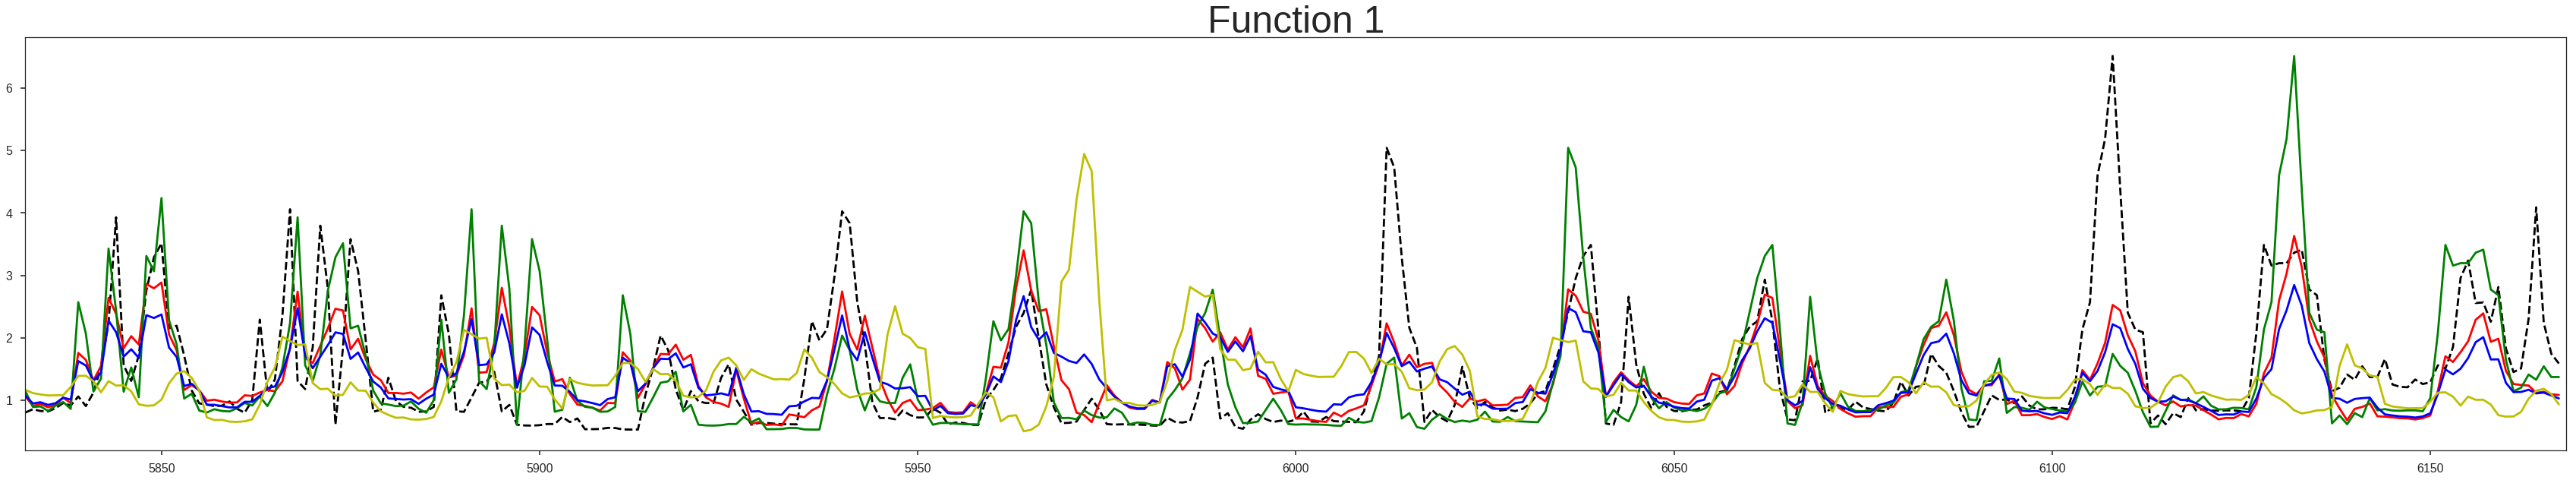

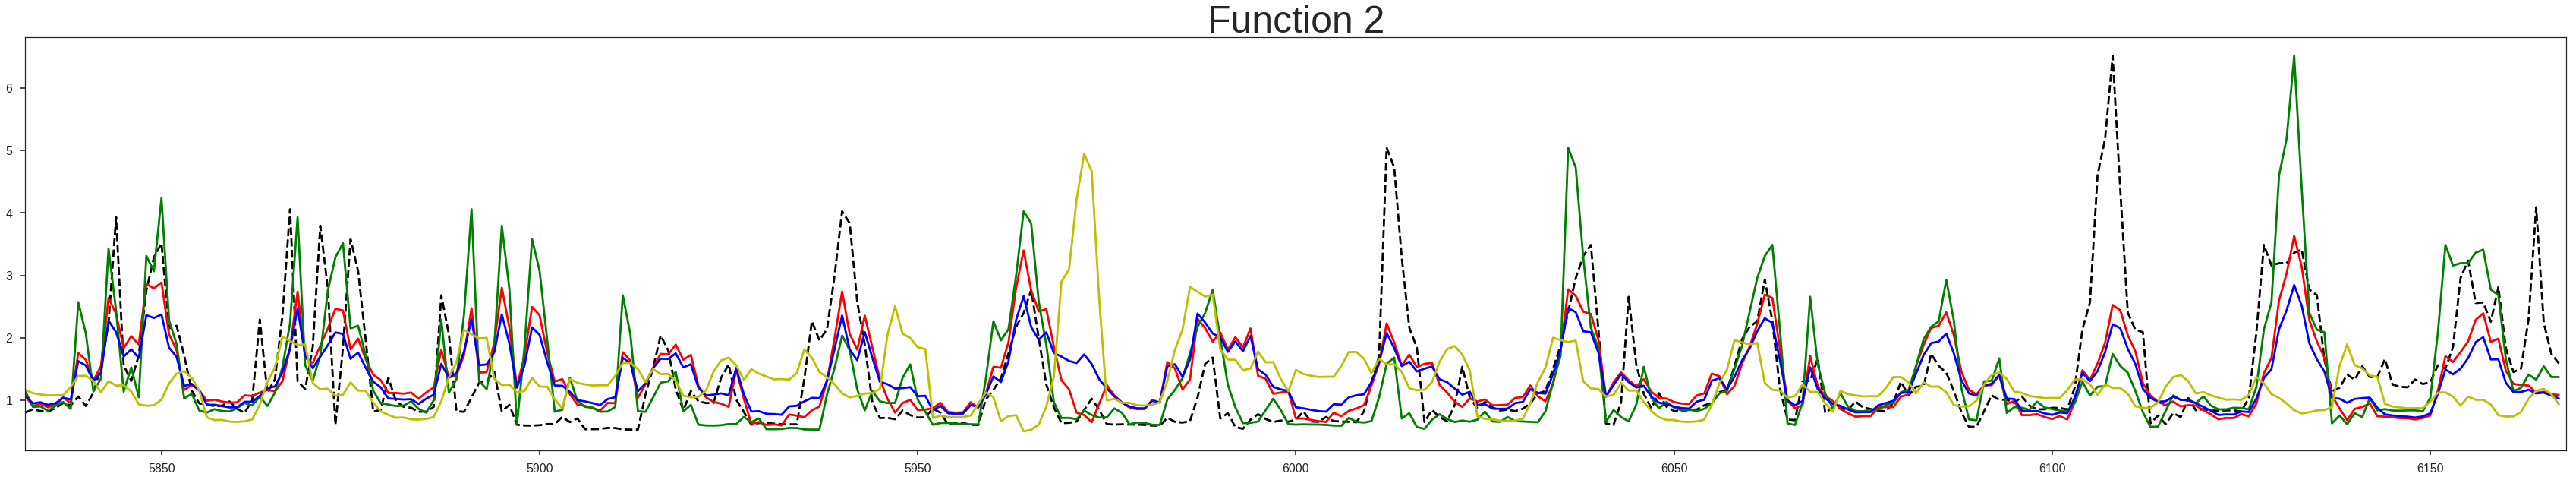

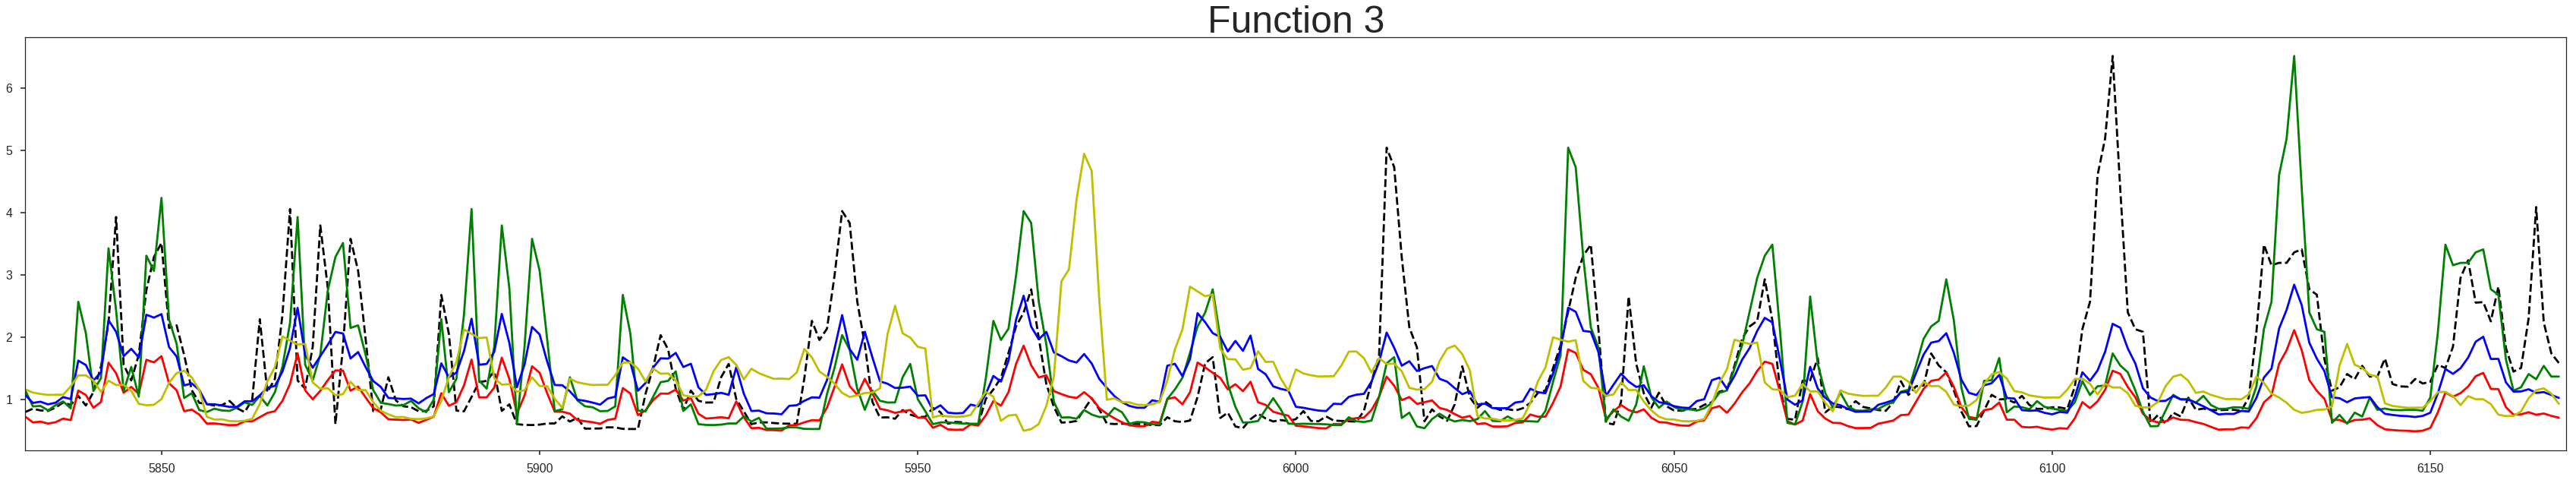

In [364]:
nU = 79

data=actualIndividual[nU, window[0]:window[1]]
ses=seasonalNaive1Individual[nU, window[0]:window[1]]
reg=predQuadraticTempIndividual[nU,window[0]:window[1]]
clu=clusterPredictedLoads3[nU,window[0]:window[1]]
x=   np.arange(plotStart,plotEnd)   

v=[]
v.append(np.mean(abs(data-ses)/abs(data)))
v.append(np.mean(abs(data-reg)/abs(data)))
v.append(np.mean(abs(data-clu)/abs(data)))
minimo=np.where(v==min(v))[0][0]

params = lm.Parameters()

#you can decide to force one the best Mapes to 1 adding delta otherwise all the parameter will vary between -1,1
delta=0

if minimo==0 and delta==1:
    params.add('a', value=1,vary=False)
else:
    params.add('a', value=0.0, min=-2, max=2)
if minimo==1 and delta==1:
    params.add('b', value=1,vary=False)
else:
    params.add('b', value=0.0, min=-2, max=2)
if minimo==2 and delta==1:
    params.add('c', value=1,vary=False)
else:
    params.add('c', value=0.0, min=-2, max=2)


    
error_model={}
error_model['green-ses'] = np.mean( np.abs(data-ses)/np.abs(data) )
error_model['blu-reg'] = np.mean( np.abs(data-reg)/np.abs(data) )
error_model['yellow-clu'] = np.mean( np.abs(data-clu)/np.abs(data) )
print 'Mapes'
print error_model
    
#select the correct function, with the function3 we are going really low in the Mape
minner = lm.Minimizer(function1, params, fcn_args=(data,ses,reg,clu) )
result = minner.minimize(method='tnc')

combination=result.params['a'].value*ses+result.params['b'].value*reg+result.params['c']*clu
plt.figure(figsize = (60,10))
plt.plot(x, data, color='k', linestyle='--')

plt.plot(x, combination, color='r')
plt.plot(x, ses, color='g')
plt.plot(x, reg, color='b')
plt.plot(x, clu, color='y')
plt.xlim([plotStart,plotEnd])
plt.title('Function 1',fontsize=50)

error_model['red-combi'] = np.mean( np.abs(data-combination)/np.abs(data) )
print 'Function 1  red line'
print error_model['red-combi']



minner = lm.Minimizer(function2, params, fcn_args=(data,ses,reg,clu) )
result = minner.minimize(method='tnc')

combination=result.params['a'].value*ses+result.params['b'].value*reg+result.params['c']*clu
plt.figure(figsize = (60,10))
plt.plot(x, data, color='k', linestyle='--')

plt.plot(x, combination, color='r')
plt.plot(x, ses, color='g')
plt.plot(x, reg, color='b')
plt.plot(x, clu, color='y')
plt.xlim([plotStart,plotEnd])
plt.title('Function 2',fontsize=50)

error_model['red-combi'] = np.mean( np.abs(data-combination)/np.abs(data) )
print 'Function 2  red line'
print error_model['red-combi']


minner = lm.Minimizer(function3, params, fcn_args=(data,ses,reg,clu) )
result = minner.minimize(method='tnc')

combination=result.params['a'].value*ses+result.params['b'].value*reg+result.params['c']*clu
plt.figure(figsize = (60,10))
plt.plot(x, data, color='k', linestyle='--')

plt.plot(x, combination, color='r')
plt.plot(x, ses, color='g')
plt.plot(x, reg, color='b')
plt.plot(x, clu, color='y')
plt.xlim([plotStart,plotEnd])
plt.title('Function 3',fontsize=50)
error_model['red-combi'] = np.mean( np.abs(data-combination)/np.abs(data) )
print 'Function 3 red line'
print error_model['red-combi']

In [349]:
result.params

Parameters([('a', <Parameter 'a', -0.33056239342397786, bounds=[-2:2]>),
            ('b', <Parameter 'b', 0.83372740598039252, bounds=[-2:2]>),
            ('c', <Parameter 'c', 0.90307247150115888, bounds=[-2:2]>)])

In [259]:
result.params

Parameters([('a',
             <Parameter 'a', value=-0.13599323214026637 +/- 0.0267, bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=0.26131399688892065 +/- 0.0389, bounds=[-inf:inf]>),
            ('c',
             <Parameter 'c', value=0.1466060324085984 +/- 0.0191, bounds=[-inf:inf]>)])

In [264]:
result.params

Parameters([('a',
             <Parameter 'a', value=-0.13599323214026637 +/- 0.0267, bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=0.26131399688892065 +/- 0.0389, bounds=[-inf:inf]>),
            ('c',
             <Parameter 'c', value=0.1466060324085984 +/- 0.0191, bounds=[-inf:inf]>)])